# QDA
Use covariance shrinkage for better QDA (Quadratic Discriminant Analysis)

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import covariance_DRO
from sklearn.covariance import LedoitWolf, EmpiricalCovariance

from warnings import warn, filterwarnings

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
np.random.seed(0)

In [4]:
loc1, loc2 = np.array([-1., -1.]), np.array([0., 1.])
sigma1, sigma2 = np.array([[1, 0.5],[0.5, 0.5]]), np.array([[0.5, 0.5],[0.5, 1]])
n1_train, n2_train = 8, 8
n1_test, n2_test = 10000, 10000

In [5]:
X_train = np.vstack([np.hstack([np.random.multivariate_normal(loc1, sigma1, n1_train), np.array([[0.]]*n1_train)]) , 
                     np.hstack([np.random.multivariate_normal(loc2, sigma2, n2_train), np.array([[1.]]*n2_train)])])
X_test = np.vstack([np.hstack([np.random.multivariate_normal(loc1, sigma1, n1_test), np.array([[0.]]*n1_test)]) , 
                     np.hstack([np.random.multivariate_normal(loc2, sigma2, n2_test), np.array([[1.]]*n2_test)])])

In [6]:
data = pd.DataFrame(X_train, columns=['x1', 'x2', 'y'])
data_test = pd.DataFrame(X_test, columns=['x1', 'x2', 'y'])

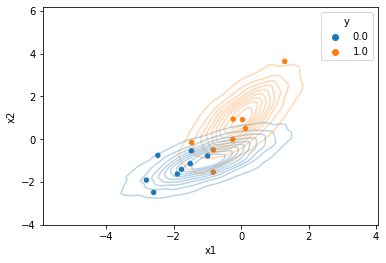

In [7]:
sns.kdeplot(x='x1', y='x2', hue='y', data=data_test, alpha=0.3)
sns.scatterplot(x='x1', y='x2', hue='y', data=data);

In [8]:
def loglikelihood(cov, data, mean):
    residuals = data - mean
    loglikelihood = -0.5 * (
        np.log(np.linalg.det(cov)) 
        + np.einsum('...j,jk,...k', residuals, np.linalg.inv(cov), residuals) 
        + len(mean) * np.log(2 * np.pi)
    )
    return loglikelihood

In [9]:
def evaluate_method(cov1, cov2, m1, m2, X_test):
    X = X_test[:,:2]
    l0 = loglikelihood(cov1, m1, X)
    l1 = loglikelihood(cov2, m2, X)
    y_hat = (l0<l1).astype(float)
    for name, score in zip(['Accuracy', 'Precision', 'Recall'], [accuracy_score, precision_score, recall_score]):
        print('{}: {}'.format(name, score(X_test[:,2], y_hat)))

## Empirical Covariance

In [10]:
c0 = EmpiricalCovariance().fit(data.loc[data.y==0][['x1', 'x2']].to_numpy())
c1 = EmpiricalCovariance().fit(data.loc[data.y==1][['x1', 'x2']].to_numpy())
evaluate_method(c0.covariance_, c1.covariance_, c0.location_, c1.location_, X_test)

Accuracy: 0.6908
Precision: 0.6253613666228647
Recall: 0.9518


## Ledoit-Wolf

In [11]:
c0 = LedoitWolf().fit(data.loc[data.y==0][['x1', 'x2']].to_numpy())
c1 = LedoitWolf().fit(data.loc[data.y==1][['x1', 'x2']].to_numpy())
evaluate_method(c0.covariance_, c1.covariance_, c0.location_, c1.location_, X_test)

Accuracy: 0.75555
Precision: 0.6842067325019823
Recall: 0.9492


## Ours

In [12]:
from tqdm import tqdm

In [13]:
def l1o_cv(X, method, epsilon_candidates):
    best_epsilons, best_accuracy = None, -1
    for e1 in tqdm(epsilon_candidates):
        for e2 in epsilon_candidates:
            y_hat = []
            for i in range(X.shape[0]):
                # train-validation split
                val = np.expand_dims(X[i,:2], 0)
                train = X[np.arange(0, X.shape[0], 1) != i]
                # find the weight
                X1, X2 = train[train[:,2]==0][:,:2], train[train[:,2]==1][:,:2]
                c1 = EmpiricalCovariance(assume_centered=False).fit(X1)
                c2 = EmpiricalCovariance(assume_centered=False).fit(X2)
                cov1 = covariance_DRO.estimate_cov(c1.covariance_, e1, method)
                cov2 = covariance_DRO.estimate_cov(c2.covariance_, e1, method)
                l0 = loglikelihood(cov1, c1.location_, val)
                l1 = loglikelihood(cov2, c2.location_, val)
                y_hat.append((l0<l1).astype(float))
            # keep track of best epsilon
            if accuracy_score(X[:,2], y_hat)>best_accuracy:
                best_accuracy = accuracy_score(X[:,2], y_hat)
                best_epsilons = (e1,e2)
    
    # warn if best epsilon is on border
    for best_epsilon in best_epsilons:
        if best_epsilon==epsilon_candidates[0]:
            print('Epsilon on left side of interval')
        if best_epsilon==epsilon_candidates[-1]:
            print('Epsilon on right side of interval')
    # return estimated covariance matrix
    X1 = X[X[:,2]==0][:,:2]
    X2 = X[X[:,2]==1][:,:2]
    return covariance_DRO.estimate_cov(EmpiricalCovariance(assume_centered=False).fit(X1).covariance_, best_epsilons[0], method), covariance_DRO.estimate_cov(EmpiricalCovariance(assume_centered=False).fit(X2).covariance_, best_epsilons[1], method)

In [14]:
filterwarnings('ignore')
c1, c2 = l1o_cv(X_train, 'KLdirect', np.logspace(-5,2,50))
evaluate_method(c1, c2, X_train[X_train[:, 2]==0][:,:2].mean(), X_train[X_train[:, 2]==1][:,:2].mean(), X_test)

100%|██████████| 50/50 [01:29<00:00,  1.79s/it]

Epsilon on left side of interval
Epsilon on left side of interval
Accuracy: 0.7493
Precision: 0.6886920980926431
Recall: 0.9099


In [15]:
c1, c2 = l1o_cv(X_train, 'Wasserstein', np.logspace(-5,2,50))
evaluate_method(c1, c2, X_train[X_train[:, 2]==0][:,:2].mean(), X_train[X_train[:, 2]==1][:,:2].mean(), X_test)

100%|██████████| 50/50 [01:27<00:00,  1.76s/it]

Epsilon on left side of interval
Epsilon on left side of interval
Accuracy: 0.7491
Precision: 0.6887121212121212
Recall: 0.9091


In [16]:
c1, c2 = l1o_cv(X_train, 'Fisher-Rao', np.logspace(-5,2,50))
evaluate_method(c1, c2, X_train[X_train[:, 2]==0][:,:2].mean(), X_train[X_train[:, 2]==1][:,:2].mean(), X_test)

100%|██████████| 50/50 [01:15<00:00,  1.51s/it]

Epsilon on left side of interval
Accuracy: 0.5295
Precision: 0.5152328823711659
Recall: 0.9978
